# BAIT 508 Group Project: Industry Analysis

`Team members`: Christi Mariam Denny and Young Ji Tuen

`Overview`: The goal of this project is to analyze public US firms within the 'Food Stores' industry sector using various **data analyses** and **natural language processing (NLP)** techniques. 

`Datasets`: This project uses the following datasets:
* public_firms.csv
* major_groups.csv
* 2020_10K_item1_full.csv

In [1]:
# import the required packages for this project
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
import seaborn as sns

# Part 1. Quantitative Analysis of 'Food Stores'
## A. Industry Sector Selection and Data Filtering

In [2]:
# import 'data/public_firms.csv' as data
data = pd.read_csv("public_firms.csv")

# read the first 5 rows of data
data.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
0,1004,1994,USA,AAR CORP,1988-01-01,5080,13.375,22.487,10.463,425.814,451.395,0.024572
1,1004,1995,USA,AAR CORP,1988-01-01,5080,22.000,33.606,16.012,437.846,504.990,0.036570
2,1004,1996,USA,AAR CORP,1988-01-01,5080,30.250,51.705,23.025,529.584,589.328,0.043478
3,1004,1997,USA,AAR CORP,1988-01-01,5080,38.750,17.222,35.657,670.559,782.123,0.053175
4,1004,1998,USA,AAR CORP,1988-01-01,5080,23.875,8.250,41.671,726.630,918.036,0.057348


In [3]:
# filter data to include only companies in major group 54, 'Food Stores'
food_data = data[data['sic'].astype(str).str.startswith('54')]

# read the first 5 rows of data
food_data.head()

# str.startswith() was obtained from Parewa Labs Pvt. Ltd
# https://www.programiz.com/python-programming/methods/string/startswith 

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
948,1240,1994,USA,ALBERTSON'S INC,NaN,5411,29.0000,50.224,400.365,3621.729,11894.621,0.110545
949,1240,1995,USA,ALBERTSON'S INC,NaN,5411,32.8750,69.113,464.961,4135.911,12585.034,0.112420
950,1240,1996,USA,ALBERTSON'S INC,NaN,5411,35.6250,90.865,493.779,4714.633,13776.678,0.104733
951,1240,1997,USA,ALBERTSON'S INC,NaN,5411,47.2500,108.083,516.814,5218.590,14689.511,0.099033
952,1240,1998,USA,ALBERTSON'S INC,NaN,5411,63.6875,80.646,567.153,6233.968,16005.115,0.090978


In [4]:
# count unique fiscal year ('fyear') observations in food_data
food_data['fyear'].nunique()

27

In [5]:
# count unique firms ('conm') in food_data
food_data['gvkey'].nunique()

104

In [6]:
# calculate the range of 'fyear' for each firm and save it as a dataframe
fyear_range = pd.DataFrame(food_data.groupby('conm')['fyear'].max() - food_data.groupby('conm')['fyear'].min())

# filter the dataframe for firms whose 'fyear' range is 26 (i.e., 2020 - 1994 = 26)
fyear_full = fyear_range[fyear_range['fyear'] == 26]

# rename the column 'fyear' to 'fyear_range'
fyear_full.columns = ['fyear_range']

# display fyear_full
fyear_full

,fyear_range
conm,
CASEYS GENERAL STORES INC,26


## B. Preliminary Analysis of Food Store Firms
### Top 10 firms with the highest stock price in 2020

In [7]:
# filter food_data for firm data in the year 2020
y2020 = food_data[food_data['fyear'] == 2020]

# display the top 10 firms with the highest stock price ('prcc_c')
y2020.sort_values(by = 'prcc_c', ascending = False)[:10]

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
7023,2807,2020,USA,CASEYS GENERAL STORES INC,NaN,5412,178.620,336.545,312.900,4460.314,7654.189,0.070152
42252,11343,2020,USA,WEIS MARKETS INC,NaN,5411,47.810,136.612,118.917,1820.421,4112.601,0.065324
49746,12972,2020,USA,INGLES MARKETS INC -CL A,NaN,5411,42.660,6.904,178.601,1899.299,4610.609,0.094035
204116,189579,2020,USA,GROCERY OUTLET HLDNG CORP,2019-06-20,5411,39.250,105.326,106.713,2485.624,3134.640,0.042932
22180,6502,2020,USA,KROGER CO,NaN,5411,31.760,1687.000,2585.000,48662.000,132498.000,0.053122
80174,23667,2020,NLD,KONINKLIJKE AHOLD DELHAIZE,NaN,5411,28.276,3507.673,1683.924,49049.567,90085.728,0.034331
41530,11178,2020,USA,VILLAGE SUPER MARKET -CL A,NaN,5411,22.060,111.681,24.939,915.546,1804.594,0.027239
66887,17934,2020,USA,SPROUTS FARMERS MARKET,2013-08-01,5411,20.100,169.697,287.450,2806.404,6468.759,0.102426
89039,25645,2020,USA,ALBERTSONS COS INC,2020-06-26,5411,17.580,1717.000,850.200,26598.000,69690.400,0.031965
133880,63904,2020,BRA,COMPANHIA BRASILEIRA DE DIST,1997-05-28,5411,14.320,1656.817,414.442,10177.701,9589.608,0.040721


### Top 10 firms with the highest sales from 1994 - 2020

In [9]:
# calculate the sum of sales for each company 
total_sale = pd.DataFrame(food_data.groupby('conm')['sale'].sum())

# rename the column 'sale' to 'total_sales'
total_sale.columns = ['total_sales']

# display the top 10 firms with the highest sales ('sale')
total_sale.sort_values('total_sales', ascending = False)[:10]

,total_sales
conm,
KROGER CO,1959875.356
KONINKLIJKE AHOLD DELHAIZE,1285153.198
SAFEWAY INC,650414.600
PUBLIX SUPER MARKETS INC,568923.550
DELHAIZE GROUP - ETS DLHZ FR,420677.596
ALBERTSON'S INC,332439.038
ITO-YOKADO CO LTD,302131.826
COMPANHIA BRASILEIRA DE DIST,274569.641
ALBERTSONS COS INC,192680.000


### Top 10 locations with the highest number of firms

In [9]:
# count the number of unique firms in each location 
geo_data = pd.DataFrame(food_data.groupby('location')['conm'].nunique())

# rename the column 'comn' to 'firm_count'
geo_data.columns = ['firm_count']

# display the top 10 locations with the highest number of firms
geo_data.sort_values('firm_count', ascending = False)[:10]

,firm_count
location,
USA,88
CHL,4
CHN,3
BRA,2
JPN,2
ARG,1
BEL,1
CAN,1
ISR,1


### Average stock price across the years

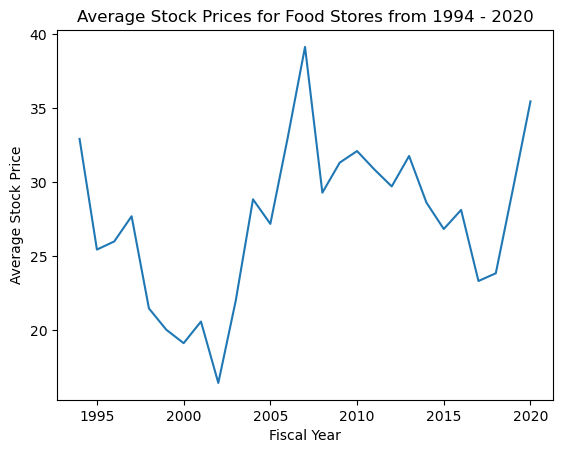

In [10]:
# calculate the average stock price for each fyear across all firms in the Food Stores sector
avg_stock = pd.DataFrame(food_data.groupby('fyear')['prcc_c'].mean())
avg_stock

# plot the average stock price from 1994 to 2020
plt.plot(avg_stock)
plt.xlabel('Fiscal Year')
plt.ylabel('Average Stock Price')
plt.title('Average Stock Prices for Food Stores from 1994 - 2020')
plt.savefig('avg_stock.png')
plt.show()

### The effect of the 2008 Financial Crisis

In [11]:
# filter food_data for reports in the year 2007
y2007 = food_data[food_data['fyear'] == 2007]

# filter food_data for reports in the year 2008
y2008 = food_data[food_data['fyear'] == 2008]

# merge y2007 and y2008 to include all firms with data in 2008
y2007_08 = pd.merge(y2007, y2008, on = 'conm', how = 'right', suffixes = ['_07', '_08'])

# calculate the percentage difference between the stock prices of each firm in 2007 and 2008
y2007_08['prcc_c_drop'] = ((y2007_08['prcc_c_08'] - y2007_08['prcc_c_07']) / y2007_08['prcc_c_07']) * 100

# display data for the firm that experienced the largest percentage drop in their stock price between 2008 and 2007
y2007_08.sort_values('prcc_c_drop')[:1]

,gvkey_07,fyear_07,location_07,conm,ipodate_07,sic_07,prcc_c_07,ch_07,ni_07,asset_07,...,location_08,ipodate_08,sic_08,prcc_c_08,ch_08,ni_08,asset_08,sale_08,roa_08,prcc_c_drop
4,8439.0,2007.0,USA,PENN TRAFFIC CO,1987-05-01,5411.0,13.5,20.916,-41.708,262.449,...,USA,1987-05-01,5411,0.7,56.434,-17.597,193.714,872.302,-0.09084,-94.814815


### Average ROA for USA firms

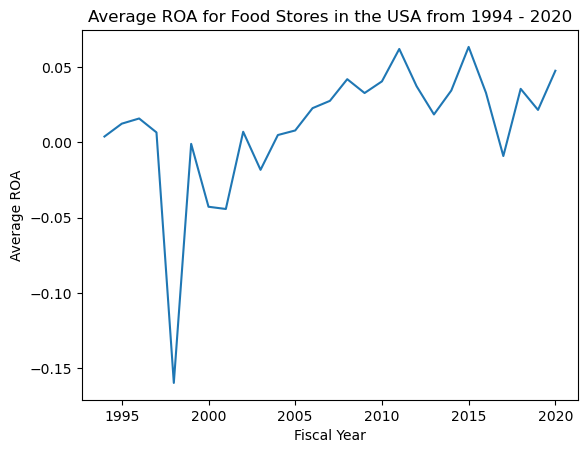

In [12]:
# select only observations in the USA
usa_data = food_data[food_data['location'] == 'USA']

# calculate the average ROA for firms in the USA across the years
avg_usa_roa = pd.DataFrame(usa_data.groupby('fyear')['roa'].mean())
avg_usa_roa

# plot the average ROA for firms in the USA from 1994 to 2020 
plt.plot(avg_usa_roa)
plt.xlabel('Fiscal Year')
plt.ylabel('Average ROA')
plt.title('Average ROA for Food Stores in the USA from 1994 - 2020')
plt.savefig('avg_usa_roa.png')
plt.show()

# Part 2. Text Analysis on the Food Stores sector
## C. Text Cleaning

In [13]:
# import 'data/public_firms.csv' as report_data
report_data = pd.read_csv('2020_10K_item1_full.csv')

# remove duplicate rows and keep the first observation
report_data = report_data.drop_duplicates(keep = 'first')

# take a look at report_data
report_data

# drop_duplicates() was obtained from NumFocus, Inc. 
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

,cik,year,name,item_1_text,gvkey
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614
12,1593204,2020,Adaiah Distribution Inc,General Adaiah Distribution Inc. was incorpora...,23706
...,...,...,...,...,...
5476,740664,2020,R F INDUSTRIES LTD,"General RF Industries, Ltd. (together with sub...",2829
5477,1074828,2020,"KNOW LABS, INC.","BACKGROUND AND CAPITAL STRUCTURE Know Labs, In...",166430
5478,40570,2020,GEE Group Inc.,"General GEE Group Inc. (the Company , us , ...",5050
5479,1341726,2020,"GULFSLOPE ENERGY, INC.","General GulfSlope Energy, Inc. is an independe...",175595


In [14]:
# define how we want to remove punctuations
translator = str.maketrans('', '', string.punctuation)

In [15]:
# download the english stopwords that are not wanted
nltk.download('stopwords')

# define the english stopwords that are not wanted
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/youngjituen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# create a function to clean a given string
def clean_text(text):
    '''takes a given string, converts it into lower case, 
    and removes punctuations and stopwords'''
    
    # convert all words in clean_text to lowercase
    clean_text = text.lower()
    
    # remove punctuation from clean_text
    clean_text = clean_text.translate(translator)
    
    # remove stopwords from clean_text and append it to the clean_words list
    clean_words = [w for w in clean_text.split() if w not in sw]
    
    # concatenate all the words in clean_words as a string
    return ' '.join(clean_words)

In [17]:
# clean the item 1 text and store it in a new column ('item_1_clean')
report_data['item_1_clean'] = report_data['item_1_text'].apply(clean_text)

# take a look at report_data
report_data

,cik,year,name,item_1_text,gvkey,item_1_clean
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119,fixed expenses previosuly documented 8k 235000...
1,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio...",5788,general hurco companies inc international indu...
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",We have been engaged in the business of develo...,27584,engaged business developing marketing products...
3,1191334,2020,Chun Can Capital Group,CORPORATE HISTORY Chun Can Capital Group (form...,153614,corporate history chun capital group formerly ...
12,1593204,2020,Adaiah Distribution Inc,General Adaiah Distribution Inc. was incorpora...,23706,general adaiah distribution inc incorporated s...
...,...,...,...,...,...,...
5476,740664,2020,R F INDUSTRIES LTD,"General RF Industries, Ltd. (together with sub...",2829,general rf industries ltd together subsidiarie...
5477,1074828,2020,"KNOW LABS, INC.","BACKGROUND AND CAPITAL STRUCTURE Know Labs, In...",166430,background capital structure know labs inc inc...
5478,40570,2020,GEE Group Inc.,"General GEE Group Inc. (the Company , us , ...",5050,general gee group inc company us incorporated ...
5479,1341726,2020,"GULFSLOPE ENERGY, INC.","General GulfSlope Energy, Inc. is an independe...",175595,general gulfslope energy inc independent crude...


## D. Keyword Analysis

In [18]:
# merge the 2020 report and firm data so that only the firms in the 'Food Stores' sector remain
food_reports = pd.merge(report_data, food_data, on = 'gvkey', how = 'inner')

# only keep merged data for firms that have data in the year 2020
food_reports = food_reports[food_reports['fyear'] == 2020]

# keep only the firm name, gvkey, and cleaned item 1 data
food_reports = food_reports[['name', 'gvkey', 'item_1_clean']]

# take a look at food_reports
food_reports

,name,gvkey,item_1_clean
9,"Sprouts Farmers Market, Inc.",17934,sprouts farmers market operates healthy grocer...
60,WEIS MARKETS INC,11343,weis markets inc pennsylvania business founded...
75,Grocery Outlet Holding Corp.,189579,company highgrowth extreme value retailer qual...
101,KROGER CO,6502,corporate history turnkey capital inc company ...
104,"Albertsons Companies, Inc.",25645,overview albertsons one largest food drug reta...
131,CASEYS GENERAL STORES INC,2807,company casey general stores inc casey whollyo...
161,VILLAGE SUPER MARKET INC,11178,jw mays inc company registrant executive offic...
187,INGLES MARKETS INC,12972,general ingles markets incorporated north caro...
198,"Natural Grocers by Vitamin Cottage, Inc.",11922,general natural grocers expanding specialty re...


### Keywords by word count

In [19]:
# create a function to generate the top 10 keywords based on their frequency in a given string
def get_keywords_wc(text):
    '''extracts the 10 most frequent terms in a given string'''
    
    # counts the frequency of each word in the given string 
    c = Counter(text.split())
    
    # empty accumulator
    words = []
    
    # append the word in the 'word and count' pairs with the top 10 highest counts 
    for pair in c.most_common(10): 
        words.append(pair[0])
        
    # concatenate the words in the accumulator into a string 
    return ' '.join(words)

In [20]:
# store the top 10 most frequent words in item 1 of each firm's 2020 report in a new column ('keyword_wc')
food_reports['keyword_wc'] = food_reports['item_1_clean'].apply(get_keywords_wc)

# check the first 5 rows of food_reports
food_reports.head()

,name,gvkey,item_1_clean,keyword_wc
9,"Sprouts Farmers Market, Inc.",17934,sprouts farmers market operates healthy grocer...,stores food store customers products believe s...
60,WEIS MARKETS INC,11343,weis markets inc pennsylvania business founded...,company stores weis store food products ﻿ 1 ma...
75,Grocery Outlet Holding Corp.,189579,company highgrowth extreme value retailer qual...,store ios us stores products customers busines...
101,KROGER CO,6502,corporate history turnkey capital inc company ...,company exchange egg inc agreement stock medix...
104,"Albertsons Companies, Inc.",25645,overview albertsons one largest food drug reta...,brands new pension food fiscal plan similar 20...


### Keywords based on TF-IDF score

In [21]:
# create a function to generate the top 10 keywords based on TF-IDF score
def get_keywords_tfidf(document_list):
    '''extracts the 10 words from each string in a given list with the highest TF-IDF scores'''
    
    # create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    
    # calculate the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(document_list)
    
    # get feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    # extract top 10 keywords for each text
    top_keywords = []
    for i in range(len(document_list)): # loop over the index of documents

        if i %100 == 0:
            print(f'Processing the {i}/{len(document_list)} document.')
        
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))
    
    return top_keywords

In [22]:
# store the top 10 words in item 1 of each firm's 2020 report with the highest TF-IDF scores
keywords = get_keywords_tfidf(food_reports.item_1_clean.tolist())

Processing the 0/9 document.


In [23]:
# store this list as a new column ('keyword_tfidf')
food_reports['keyword_tfidf'] = keywords

# check the first 5 rows of food_reports
food_reports.head()

,name,gvkey,item_1_clean,keyword_wc,keyword_tfidf
9,"Sprouts Farmers Market, Inc.",17934,sprouts farmers market operates healthy grocer...,stores food store customers products believe s...,sprouts stores food believe customers store pr...
60,WEIS MARKETS INC,11343,weis markets inc pennsylvania business founded...,company stores weis store food products ﻿ 1 ma...,weis stores company store food markets product...
75,Grocery Outlet Holding Corp.,189579,company highgrowth extreme value retailer qual...,store ios us stores products customers busines...,ios store io wow us vice stores products offic...
101,KROGER CO,6502,corporate history turnkey capital inc company ...,company exchange egg inc agreement stock medix...,medixall company egg rom agreement exchange st...
104,"Albertsons Companies, Inc.",25645,overview albertsons one largest food drug reta...,brands new pension food fiscal plan similar 20...,pension plants brands felra plan new fiscal fo...


### Creating a word cloud based on word count

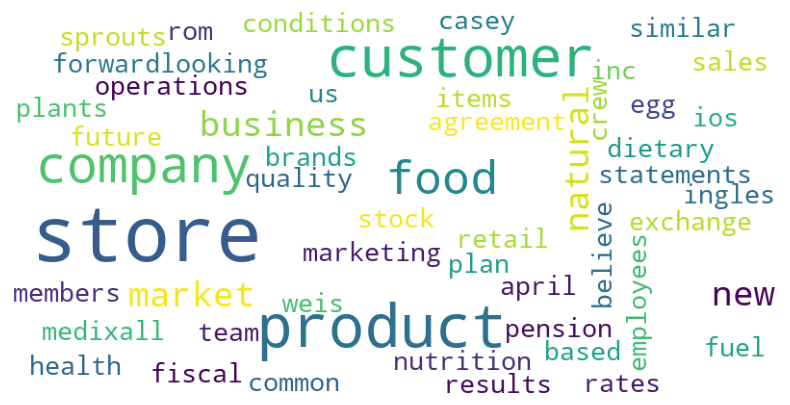

In [24]:
# prepare keyword_wc text by concatenating all the words into a list  
text_wc = ' '.join(food_reports['keyword_wc'].tolist())

# generate a word cloud for the keywords based on word count
wordcloud_wc = WordCloud(width=800, height=400, background_color='white', max_font_size=80).generate(text_wc) 

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_wc)
plt.axis('off')
plt.savefig('keyword_wc.png')

plt.show()

### Creating a word cloud based on TF-IDF scores

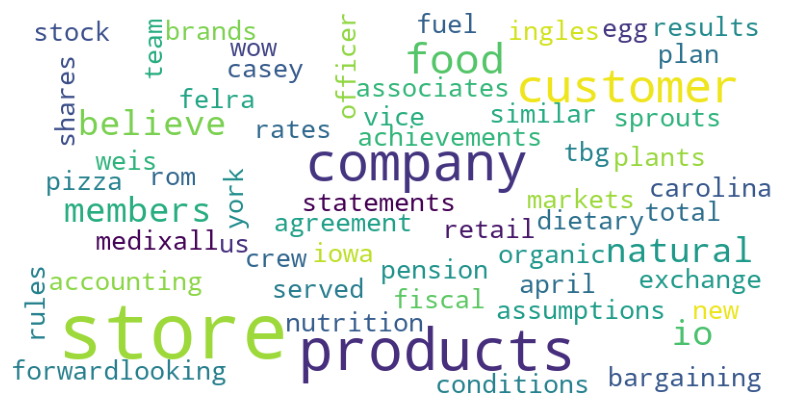

In [25]:
# prepare keyword_tfidf text by concetenating all the words into a list
text_tfidf = ' '.join(food_reports['keyword_tfidf'].tolist())

# generate a word cloud for the keywords based on TF-IDF scores
wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white', max_font_size=80).generate(text_tfidf) 

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_tfidf)
plt.axis('off')
plt.savefig('keyword_tfidf.png')

plt.show()

## E. Word Embedding
### Model training

In [26]:
# store each report's 'item_1_clean' data as words in a list, and store all lists in a list
sent = [row.split() for row in report_data['item_1_clean']]

In [27]:
# train a word2vec model using the list of word lists in `sent`
model = Word2Vec(sent, min_count=1, vector_size=50, workers=3, window=3, sg = 1)

In [28]:
# save the model
model.save('word2vec.model')

In [29]:
# load the model
model = Word2Vec.load('word2vec.model')

### Exploring relevant words

In [30]:
# extract the top 5 most relevant words to 'nutrition'
model.wv.most_similar('nutrition')[:5]

[('nutritional', 0.8800408840179443),
 ('wellness', 0.8286533355712891),
 ('nutraceuticals', 0.7870074510574341),
 ('beverage', 0.7792356610298157),
 ('beauty', 0.775907039642334)]

In [31]:
# extract the top 5 most relevant words to 'food'
model.wv.most_similar('food')[:5]

[('beverage', 0.8396865725517273),
 ('meat', 0.83620685338974),
 ('cosmetic', 0.8151929974555969),
 ('perishable', 0.8062229752540588),
 ('fruitbased', 0.8060570955276489)]

In [32]:
# extract the top 5 most relevant words to 'markets'
model.wv.most_similar('markets')[:5]

[('market', 0.8755775094032288),
 ('endmarkets', 0.8702895641326904),
 ('subsegments', 0.870010495185852),
 ('sectors', 0.8570111989974976),
 ('geographies', 0.8428289294242859)]

# Part 3. Comprehensive Analysis of 7-Eleven Inc.
## F. Firm Analysis and Strategy Suggestion

In [33]:
# subset 7-ELEVEN INC data and store in 'se_data'
se_data = food_data[food_data['conm'] == '7-ELEVEN INC']

# take a look at se_data
se_data

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa
36202,9872,1995,USA,7-ELEVEN INC,NaN,5412,3.3120,43.047,270.763,2081.117,5825.001,0.130105
36203,9872,1996,USA,7-ELEVEN INC,NaN,5412,2.9690,36.494,89.476,2039.148,5993.276,0.043879
36204,9872,1997,USA,7-ELEVEN INC,NaN,5412,2.1250,38.605,70.042,2090.081,6089.433,0.033512
36205,9872,1998,USA,7-ELEVEN INC,NaN,5412,1.9063,26.880,74.048,2415.844,6306.341,0.030651
36206,9872,1999,USA,7-ELEVEN INC,NaN,5412,1.7813,76.859,83.113,2685.666,7187.922,0.030947
36207,9872,2000,USA,7-ELEVEN INC,NaN,5412,8.7500,133.178,108.292,2742.288,8185.884,0.039490
36208,9872,2001,USA,7-ELEVEN INC,NaN,5412,11.7100,125.599,83.720,2902.829,8533.664,0.028841
36209,9872,2002,USA,7-ELEVEN INC,NaN,5412,7.5000,120.765,12.777,3064.325,8710.937,0.004170
36210,9872,2003,USA,7-ELEVEN INC,NaN,5412,16.0500,184.427,64.094,3348.903,10881.716,0.019139
36211,9872,2004,USA,7-ELEVEN INC,NaN,5412,23.9500,76.214,96.506,3312.126,12235.283,0.029137


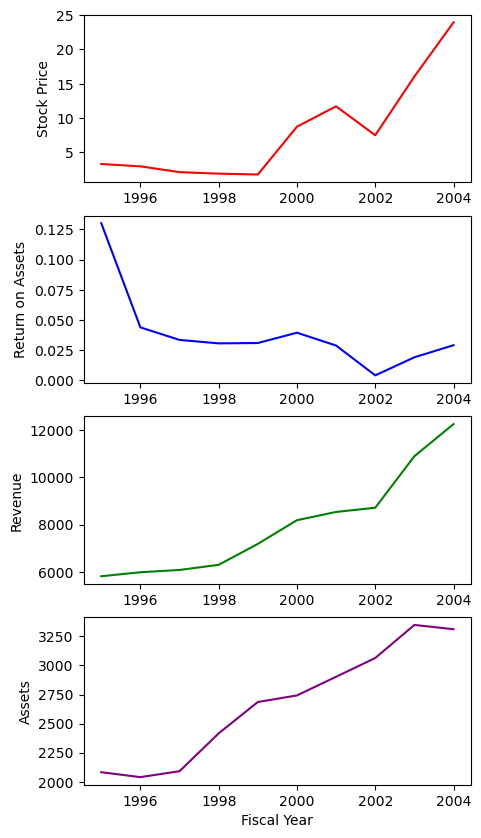

In [34]:
# plot 7-Eleven Inc.'s stock price, ROA, revenue, and assets over the years
fig, ax = plt.subplots(4, 1, figsize = (5, 10))

ax[0].plot(se_data['fyear'], se_data['prcc_c'], color = 'red')
ax[0].set_ylabel('Stock Price')

ax[1].plot(se_data['fyear'], se_data['roa'], color = 'blue')
ax[1].set_ylabel('Return on Assets')

ax[2].plot(se_data['fyear'], se_data['sale'], color = 'green')
ax[2].set_ylabel('Revenue')

ax[3].plot(se_data['fyear'], se_data['asset'], color = 'purple')
ax[3].set_ylabel('Assets')
ax[3].set_xlabel('Fiscal Year')

plt.savefig('seven_eleven.png', bbox_inches = 'tight')
plt.show()

# code for this plot was obtained from Rokem, Ariel
# https://app.datacamp.com/learn/courses/introduction-to-data-visualization-with-matplotlib

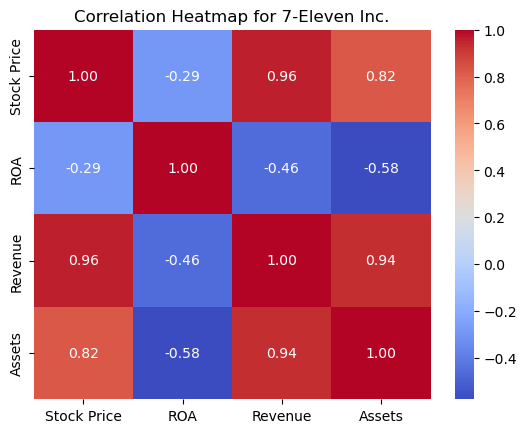

In [35]:
# plot a heat map to display the correlations between 7-Eleven Inc.'s stock price, ROA, revenue, and assets
correlation_matrix = se_data[['prcc_c', 'roa', 'sale', 'asset']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels = ['Stock Price', 'ROA', 'Revenue', 'Assets'],
            yticklabels = ['Stock Price', 'ROA', 'Revenue', 'Assets'])

plt.title('Correlation Heatmap for 7-Eleven Inc.')
plt.savefig('seven_eleven_corr.png', bbox_inches = 'tight')
plt.show()

# code for this plot was obtained from Vanshikagoyal43
# https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/ 